In [2]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose, Flatten, Reshape, Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

#from PIL import Image

%matplotlib inline

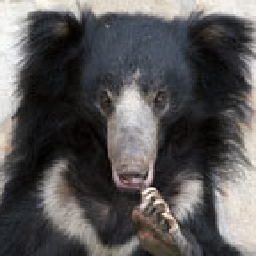

In [3]:
#path_img = './img'
path_img = '/kaggle/input/imagenet/imagenet/train/'
images = []
img_size = (256, 256)

i = 0
for filename in os.listdir(path_img):
    images.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))
    
    i+=1
    if i==1000: break

images[1]

In [8]:
def add_noise_and_convert_to_array (input_img, noise_factor=0.4):
    x_images_clear = []
    x_images_noised = []
    for img in input_img:
        img_np = (image.img_to_array(img)).astype('float32')
        #igm_np = igm_np.astype('float32')
        #img_np /= 255
        x_images_clear.append(img_np)
        #img_noised = img_np + noise_factor*K.random_normal(img_np.shape, mean=0., stddev=1.0)
        #img_noised = K.clip(img_noised, 0., 1.)
        img_noised = img_np + noise_factor*K.random_normal(img_np.shape, mean=0., stddev=255)
        img_noised = K.clip(img_noised, 0., 255.)
        x_images_noised.append(img_noised)
    return np.array(x_images_clear), np.array(x_images_noised)

images_clear, images_noised = add_noise_and_convert_to_array(images, 0.3)

<Figure size 1500x1000 with 0 Axes>

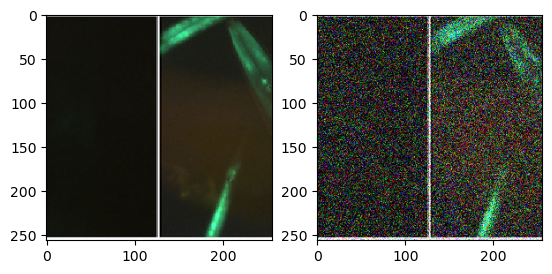

In [9]:
n=3
plt.figure(figsize=(15,10))
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(image.array_to_img(images_clear[n]))
plt.subplot(1,2,2)
plt.imshow(image.array_to_img(images_noised[n]))
image.save_img('t.jpg', image.array_to_img(images_noised[n]))
image.save_img('tc.jpg', image.array_to_img(images_clear[n]))

In [5]:
img_shape=(256, 256, 3)
latent_size = 8192

ae_v2 = Sequential(name='encoder')
ae_v2.add(InputLayer(img_shape))
ae_v2.add(Conv2D(512, kernel_size=(3,3), activation='gelu', padding='same'))
ae_v2.add(BatchNormalization())
ae_v2.add(MaxPooling2D(pool_size=(2,2)))
ae_v2.add(Conv2D(256, kernel_size=(3,3), activation='gelu', padding='same'))
ae_v2.add(BatchNormalization())
ae_v2.add(MaxPooling2D(pool_size=(2,2)))
ae_v2.add(Conv2D(128, kernel_size=(3,3), activation='gelu', padding='same'))
#ae_v2.add(BatchNormalization())
#ae_v2.add(MaxPooling2D(pool_size=(2,2)))
#ae_v2.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
#ae_v2.add(BatchNormalization())
#ae_v2.add(MaxPooling2D(pool_size=(2,2)))
#encoder.add(Flatten())
#encoder.add(Dense(latent_size))

#ae_v2 = Sequential(name='decoder')
#decoder.add(Input(shape=(16*16*32,)))
#decoder.add(Dense(16*16*32))
#decoder.add(Reshape((16,16,32)))
#ae_v2.add(Conv2DTranspose(128, kernel_size=(3,3), strides=2, activation='gelu', padding='same'))
#ae_v2.add(BatchNormalization())
ae_v2.add(Conv2DTranspose(256, kernel_size=(3,3), strides=2, activation='gelu', padding='same'))
ae_v2.add(BatchNormalization())
ae_v2.add(Conv2DTranspose(512, kernel_size=(3,3), strides=2, activation='gelu', padding='same'))
ae_v2.add(BatchNormalization())
#ae_v2.add(Conv2DTranspose(128, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
#ae_v2.add(BatchNormalization())
ae_v2.add(Conv2DTranspose(3, kernel_size=(3,3), activation=None, padding='same'))

ae_v2.summary()
#decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 512)     14336     
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 512)    2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 512)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 256)     1179904   
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 256)    1024      
 hNormalization)                                                 
                                                           

In [12]:
model = tf.keras.models.load_model('/kaggle/working/ae_v2_adamax_gelu_100_0.0054')
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 512)     14336     
                                                                 
 batch_normalization_4 (Batc  (None, 256, 256, 512)    2048      
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 512)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 256)     1179904   
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 256)    1024      
 hNormalization)                                                 
                                                           

In [16]:
#inp=Input(shape=img_shape)
#latent = encoder(inp)
#out = decoder(latent)

#ae_v2 = Model(inputs=inp, outputs=out)

In [11]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

ae_v2.compile(optimizer=Adamax(learning_rate=1e-2), loss='mse')

Epoch 1/100
250/250 [==============================] - 65s 248ms/step - loss: 35.2529 - lr: 0.0100
Epoch 2/100
250/250 [==============================] - 62s 248ms/step - loss: 25.7660 - lr: 0.0100
Epoch 3/100
250/250 [==============================] - 62s 249ms/step - loss: 26.2928 - lr: 0.0100
Epoch 4/100
250/250 [==============================] - 62s 249ms/step - loss: 24.6679 - lr: 0.0100
Epoch 5/100
250/250 [==============================] - 62s 249ms/step - loss: 25.4862 - lr: 0.0100
Epoch 6/100
250/250 [==============================] - 62s 249ms/step - loss: 24.5176 - lr: 0.0100
Epoch 7/100
250/250 [==============================] - 62s 250ms/step - loss: 24.1112 - lr: 0.0100
Epoch 8/100
250/250 [==============================] - 62s 250ms/step - loss: 23.6349 - lr: 0.0100
Epoch 9/100
250/250 [==============================] - 62s 249ms/step - loss: 23.6528 - lr: 0.0100
Epoch 10/100
250/250 [==============================] - 62s 249ms/step - loss: 22.6777 - lr: 0.0100
Epoch 11/

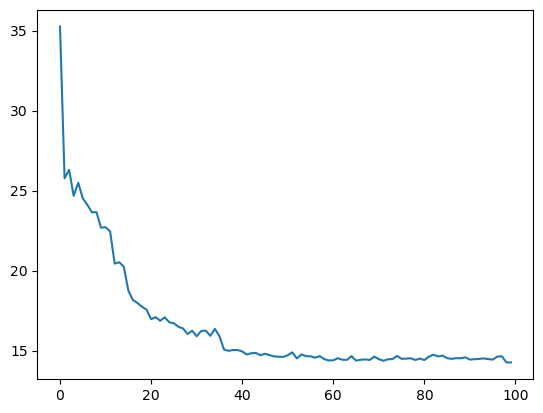

In [12]:
history = ae_v2.fit(images_noised, images_clear,
                epochs=100,
                callbacks=[reduce_lr],
                batch_size=4)

plt.plot(history.history['loss'])
plt.show()

In [1]:
ae_v2.compile(optimizer=Adamax(learning_rate=1e-13), loss='mae')
history = ae_v2.fit(images_noised, images_clear,
                epochs=50,
                #initial_epoch=101,
                callbacks=[reduce_lr],
                batch_size=4)

#plt.plot(history.history['loss'])
#plt.show()

NameError: name 'ae_v2' is not defined

In [1]:
test = images_noised[:5]
y = ae_v2.predict(test)

1/1 [==============================] - 6s 6s/step


In [2]:
def plot_result(image_clear, image_noised, image_reconstructed):
    max_value = 255
    plt.subplots(1,3, figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(image.array_to_img(image_clear))
    plt.title(f'Ground True')
    plt.subplot(1,3,2)
    plt.imshow(image.array_to_img(image_noised))
    plt.title(f'Noised, PSNR={tf.image.psnr(image_clear, image_noised, max_val=max_value)}')
    plt.subplot(1,3,3)
    plt.imshow(image.array_to_img(image_reconstructed))
    plt.title(f'Reconstructed, PSNR={tf.image.psnr(image_clear, image_reconstructed, max_val=max_value)}')
    

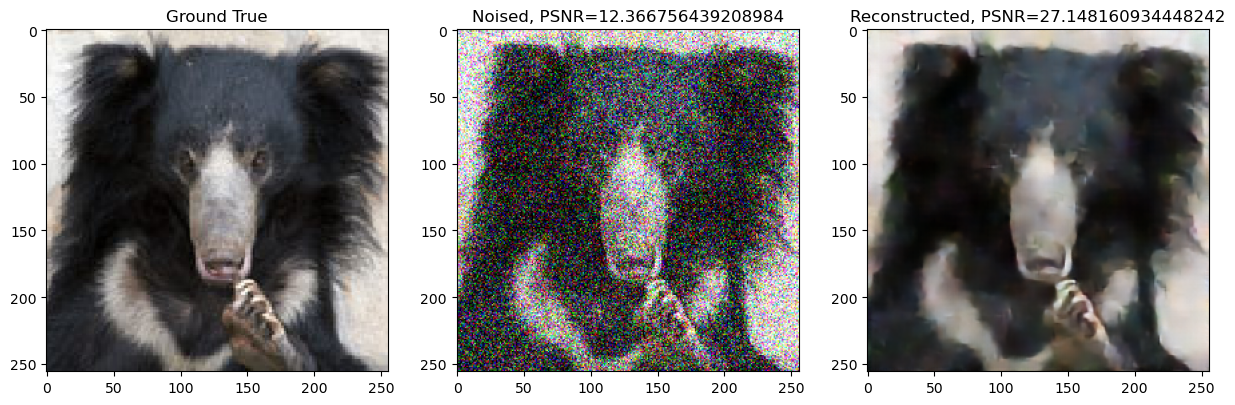

In [3]:
n=1
plot_result(images_clear[n],
            images_noised[n],
            y[n]
           )

In [92]:
1 / np.sqrt(3780.8225)
np.log10(0.016263231932649298)
#20 * np.log10(1 / np.sqrt(3780.8225))

a = tf.image.psnr(images_clear[1], y[1], max_val=1)
print (a.numpy())

26.3461


In [4]:
ae_v2.save('ae_v2_adamax_gelu_no_activ_out_no_norm_mae_100_14.25_psnr_27.148')

In [19]:
ae_v2.optimizer.variables()

ListWrapper([<tf.Variable 'iteration:0' shape=() dtype=int64, numpy=25000>, <tf.Variable 'Adamax/m/conv2d_3/kernel:0' shape=(3, 3, 3, 512) dtype=float32, numpy=
array([[[[ 1.6849543e-06, -6.5031207e-07, -1.5370294e-07, ...,
          -2.7959561e-07, -7.3984978e-07,  6.0966968e-06],
         [ 8.1122073e-07, -1.4655633e-07,  3.1025206e-07, ...,
           6.5679444e-08, -7.1821589e-08,  5.0781350e-06],
         [ 1.3820231e-06, -1.3034516e-07,  5.3583143e-08, ...,
           7.9501213e-08,  4.4634223e-08,  2.9947760e-06]],

        [[ 1.8033890e-06, -8.9833560e-07, -7.0572395e-07, ...,
          -3.5759700e-07, -1.1214863e-06,  6.4896644e-06],
         [ 8.5016251e-07, -1.7456611e-07,  2.1143811e-07, ...,
           7.0709817e-08, -6.2142647e-07,  4.2343167e-06],
         [ 1.1615268e-06, -6.8204805e-08,  8.4279563e-08, ...,
           9.9940245e-08,  8.2377063e-08,  1.7352407e-06]],

        [[ 1.8598244e-06, -8.0582583e-07, -6.0175091e-07, ...,
          -3.8945964e-07, -5.6408913e-07